In [1]:
from utils import *
import sys
import copy
import random
import time
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback,CheckpointCallback,CallbackList
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import time
import os

In [2]:
with open('dataframes.pickle', 'rb') as handle:
    loaded_dfs = pickle.load(handle)
with open('initial_dataframes.pickle', 'rb') as handle:
    loaded_initial_dfs = pickle.load(handle)

In [3]:
print(energy_monitor())

Failed to open energy_uj file: [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl:0/energy_uj'
Failed to open energy_uj file: [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl:0/energy_uj'
0


In [13]:
#loaded_dfs is the the dfs that has (previous_action,action) single action based logs 
print_empty_dataframes(loaded_dfs) 

print('\n\n\n')
#loaded_dfs is the the dfs that has only action one single action based logs 
print_empty_dataframes(loaded_initial_dfs) 


The DataFrame for key 'concurrency_1_2' has 1132 rows
The DataFrame for key 'concurrency_1_3' has 859 rows
The DataFrame for key 'concurrency_1_4' has 1297 rows
The DataFrame for key 'concurrency_1_5' has 1782 rows
The DataFrame for key 'concurrency_1_6' has 992 rows
The DataFrame for key 'concurrency_1_7' has 1249 rows
The DataFrame for key 'concurrency_1_8' has 1332 rows
The DataFrame for key 'concurrency_2_1' has 1041 rows
The DataFrame for key 'concurrency_2_3' has 350 rows
The DataFrame for key 'concurrency_2_4' has 770 rows
The DataFrame for key 'concurrency_2_5' has 931 rows
The DataFrame for key 'concurrency_2_6' has 621 rows
The DataFrame for key 'concurrency_2_7' has 601 rows
The DataFrame for key 'concurrency_2_8' has 481 rows
The DataFrame for key 'concurrency_3_1' has 984 rows
The DataFrame for key 'concurrency_3_2' has 391 rows
The DataFrame for key 'concurrency_3_4' has 520 rows
The DataFrame for key 'concurrency_3_5' has 582 rows
The DataFrame for key 'concurrency_3_6' 

In [14]:
env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
evaluation_env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
print(f'Action size: {env.action_space.n}')
total_scores=0
total_scores_round=0
s = env.reset()
action_list=[]
reward_list=[]
reward_list_round=[]
done = False
while not done:
    a=env.action_space.sample()
    if a==0:
        a=1
    s_next, r, done, info = env.step(a)
    action_list.append(a)
    reward_list.append(r)
    total_scores += r
    total_scores_round += round(r,3)
    reward_list_round.append(round(r,3))
    s = s_next    
env.close()
print(f"Total Reward: {total_scores}")
print(f"Total Reward round: {total_scores_round}")
print(f"actions {action_list},   {len(action_list)}")
print(f"rewards {reward_list},  {len(reward_list)}")
print(f"rewards round {reward_list_round},  {len(reward_list_round)}")


Action size: 9
Total Reward: 2.2
Total Reward round: 2.2
actions [4, 6, 1, 1, 3, 5, 1, 6, 6, 8, 3, 6, 6, 1, 6, 3, 8, 3, 4, 7],   20
rewards [1.8, -1.8, 0.0, 0.0, 2.0, -0.2, 1.2, 1.8, -3.6, -1.2, 0.6, 3.0, -1.6, -2.0, 0.0, 0.8, 3.8, -4.6, 1.0, 1.2],  20
rewards round [1.8, -1.8, 0.0, 0.0, 2.0, -0.2, 1.2, 1.8, -3.6, -1.2, 0.6, 3.0, -1.6, -2.0, 0.0, 0.8, 3.8, -4.6, 1.0, 1.2],  20


In [5]:
env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
evaluation_env=transferClass(loaded_dfs,loaded_initial_dfs,'random')

policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[{'pi': [128, 128], 'vf': [128, 128]}])
model = PPO("MlpPolicy", env=env, policy_kwargs=policy_kwargs, verbose=1,tensorboard_log="./ppo_tensorboard/",ent_coef=0.01)
eval_callback = EvalCallback(evaluation_env, best_model_save_path='./ppo/ppo_best_model/',
                               log_path='./ppo/ppo_logs/', eval_freq=1000,
                               deterministic=True, render=False)
# Callback for saving checkpoints every 1000 timesteps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='./ppo/ppo_checkpoints/',
                                           name_prefix='ppo_model')

# Combine both callbacks
callback = CallbackList([checkpoint_callback, eval_callback])
model.learn(total_timesteps=2000000, callback=callback)

In [6]:

####       RL PPO   SB3

num_of_run=50

rl_throughput_list=[]
rl_energy_list=[]
rl_plr_list=[]


model = PPO.load("./ppo_1M_simulator/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(int(action))
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    env.close()
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
    rl_throughput_list.append(accumulator_df['Throughput'].mean())
    rl_energy_list.append(accumulator_df['Energy'].sum())
    rl_plr_list.append(accumulator_df['sender_lr'].sum())
#     print(accumulator_df.describe())

Episode reward: 5.0
actions [7, 5, 6, 5, 7, 5, 6, 7, 7, 5, 6, 7, 7, 5, 6, 7, 7, 7, 5, 6],   20
rewards [0.0, 2.0, 3.6, -0.6, -5.0, 0.0, 2.2, 2.4, -2.0, -0.6, 3.2, -1.4, -1.6, 2.2, -1.2, -2.0, 1.6, 1.8, -2.4, 2.8],  20
Average Throughput 3.3408
Total Energy 6292.0
Total packet loss 0.0011029999999999998
Episode reward: 0.39999999999999913
actions [7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 7, 5, 6, 7, 5, 6, 7, 5, 6],   20
rewards [2.8, 4.0, -3.4, -0.2, -1.8, -0.4, 4.4, -5.4, 3.0, 3.8, -7.4, 3.4, -0.6, 4.0, -6.0, 5.2, 1.4, -2.8, -4.0, 0.4],  20
Average Throughput 3.5904
Total Energy 6313.0
Total packet loss 0.465679
Episode reward: 1.9999999999999996
actions [7, 5, 5, 6, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 4, 6, 7],   20
rewards [2.8, -2.8, 3.0, -0.4, -0.6, 0.8, -2.0, 4.4, -4.0, 1.4, -2.2, 3.4, -1.6, 3.6, -3.4, -1.6, 6.0, -5.4, 1.0, -0.4],  20
Average Throughput 2.8959999999999995
Total Energy 4992.0
Total packet loss 0.14625099999999996
Episode reward: 2.3999999999999995
actions [7, 5, 6, 6, 5

Episode reward: 1.4000000000000008
actions [7, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 5, 6, 7, 5, 6, 7, 5],   20
rewards [1.8, -0.8, 1.0, 2.4, 2.2, -4.4, -1.2, 0.6, -1.6, 4.8, -3.8, 0.0, -0.8, 0.6, 0.2, 0.6, -1.2, 5.4, -5.8, 1.4],  20
Average Throughput 2.0832
Total Energy 5941.0
Total packet loss 0.043967
Episode reward: 4.6
actions [7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5],   20
rewards [0.0, 1.0, -1.0, 5.0, -2.8, -1.2, 3.2, -3.0, 2.2, -2.4, 1.4, 5.2, 0.4, -6.0, -1.0, 1.0, -2.0, 1.0, 0.0, 3.6],  20
Average Throughput 2.7455999999999996
Total Energy 6539.0
Total packet loss 0.021464999999999995
Episode reward: 0.9999999999999991
actions [7, 5, 6, 5, 6, 7, 5, 5, 6, 7, 5, 6, 7, 5, 6, 5, 6, 7, 5, 6],   20
rewards [4.8, -3.4, -1.4, 1.4, 3.8, -2.2, -3.0, 1.6, 2.4, 1.0, -3.0, 2.8, -4.8, 6.6, -6.6, 4.2, 0.8, -4.0, -1.0, 1.0],  20
Average Throughput 2.8735999999999997
Total Energy 5835.0
Total packet loss 0.08504400000000001
Episode reward: 1.5999999999999996
actions [7, 5, 6,

In [7]:

####       RL PPO   SB3

num_of_run=50

rl_2M_throughput_list=[]
rl_2M_energy_list=[]
rl_2M_plr_list=[]


model = PPO.load("./ppo/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(int(action))
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    env.close()
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
    rl_2M_throughput_list.append(accumulator_df['Throughput'].mean())
    rl_2M_energy_list.append(accumulator_df['Energy'].sum())
    rl_2M_plr_list.append(accumulator_df['sender_lr'].sum())
#     print(accumulator_df.describe())

Episode reward: 1.1999999999999993
actions [6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 5, 6, 7, 5, 6, 7, 5],   20
rewards [5.8, -4.0, 0.8, -0.4, 2.0, -4.2, 2.0, 3.4, -1.2, -3.2, 5.4, -5.4, 5.0, -3.8, 0.6, -1.8, 2.4, 3.2, -0.8, -4.6],  20
Average Throughput 3.7376
Total Energy 6417.0
Total packet loss 0.09987700000000001
Episode reward: 1.4
actions [6, 7, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 7, 5, 6, 7, 5, 6, 5, 6],   20
rewards [1.0, 1.4, -0.4, 5.4, -7.4, 1.6, -0.6, 0.0, 0.0, 1.2, 2.8, 0.4, -3.6, -0.8, 5.2, -5.2, 3.0, -3.0, 1.0, -0.6],  20
Average Throughput 2.6976000000000004
Total Energy 5965.0
Total packet loss 0.148666
Episode reward: 0.1999999999999993
actions [6, 5, 6, 7, 5, 6, 7, 5, 6, 5, 6, 6, 5, 6, 5, 6, 7, 5, 6, 7],   20
rewards [0.6, 0.4, 4.6, -0.8, -3.6, -0.2, 3.4, 0.2, -3.6, -1.0, 5.8, -5.8, 2.6, -2.0, 0.4, 0.8, 0.2, -2.0, 2.0, -1.8],  20
Average Throughput 2.3072
Total Energy 5830.0
Total packet loss 0.08528100000000001
Episode reward: 3.8000000000000003
actions [6, 7, 5, 6, 7, 5, 6

Episode reward: 1.6
actions [6, 5, 6, 7, 5, 6, 7, 5, 6, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6],   20
rewards [1.0, -1.0, 4.8, -4.8, 4.2, -2.4, -0.8, 4.0, 2.0, -2.4, -2.4, 0.0, 2.6, -3.8, 4.8, -5.8, 1.2, -1.2, 0.0, 1.6],  20
Average Throughput 2.7039999999999997
Total Energy 5701.0
Total packet loss 0.036770000000000004
Episode reward: 2.6
actions [6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 7, 5],   20
rewards [2.0, -1.2, 1.8, -0.8, -0.8, 3.6, -1.2, -2.4, 4.0, -4.0, 2.6, -3.6, 3.6, -2.6, 1.0, -2.0, 1.4, 6.0, -5.4, 0.6],  20
Average Throughput 2.5792
Total Energy 6064.0
Total packet loss 0.018951
Episode reward: 1.4000000000000006
actions [6, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5, 6, 7, 5],   20
rewards [0.6, 3.0, 1.4, 0.2, 2.8, -7.4, 0.6, 2.6, -2.6, 4.8, -5.0, 1.0, 2.8, -3.8, -0.6, 4.2, -1.8, 1.6, -1.8, -1.2],  20
Average Throughput 3.4176000000000006
Total Energy 6354.0
Total packet loss 0.16392500000000002
Episode reward: 6.199999999999999
actions [6, 7, 5, 6, 7, 5, 6, 7

In [8]:
####       BO

from optimizer_gd import *

bo_throughput_list=[]
bo_energy_list=[]
bo_plr_list=[]
for i in range(0,num_of_run):

    env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
    print("BO is running")
    initial_state = env.reset()
    best_params = bayes_optimizer(env)
    print(f"Optimal parameters: {best_params}")
    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
#     print(accumulator_df.describe())
    bo_throughput_list.append(accumulator_df['Throughput'].mean())
    bo_energy_list.append(accumulator_df['Energy'].sum())
    bo_plr_list.append(accumulator_df['sender_lr'].sum())
    env.close()

BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [3] and Score: -2.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.09 Seconds. Best Params: [3] and Score: -2.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -2.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 3.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -6.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -6.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.1 Seconds. Best Params: [1] and Score: -6.0.
Iteration 9 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 9 Ends, Took 0.3 Seconds. Best Params: [1] and Score: -6.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.05 Seconds. Best Params: [2] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.05 Seconds. Best Params: [2] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.05 Seconds. Best Params: [2] and Score: -0.0.
Iteration 15 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15 Ends, Took 0.06 Seconds. Best Params: [2] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.06 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.11 Seconds. Best Params: [2] and Score: -0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.12 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.0656
Total Energy 4410.0
Total packet loss 0.019296
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.0 Seconds. Best Params: [6] and Score: -4.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [6] and Score: -4.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.17 Seconds. Best Params: [6] and Score: -4.0.
Iteration 4 Starts ...
Iter

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.16 Seconds. Best Params: [1] and Score: -3.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -3.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.12 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.4784
Total Energy 5002.0
Total packet loss 0.021043
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -0.0.

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.1136
Total Energy 4603.0
Total packet loss 0.033195
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [9] and Score: -7.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [4] and Score: 7.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.0 Seconds. Best Params: [3] and Score: -0.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.0 Seconds. Best Params: [4] and Score: -2.0.
Iteration 5 Starts ...
Iterati

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.32 Seconds. Best Params: [1] and Score: 0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -3.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -3.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -3.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.5871999999999997
Total Energy 5157.0
Total packet loss 0.804871
BO is running
Iterati

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 6 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -2.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.16 Seconds. Best Params: [1] and Score: -2.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.13 Seconds. Best Params: [1] and Score: 0.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -2.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 2.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -4.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.5008000000000001
Total Energy 4893.0
Total packet loss 0.008863
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [9] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.12 Seconds. Best Params: [2] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 5 Star

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15 Ends, Took 0.32 Seconds. Best Params: [1] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -0.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.0688000000000002
Total Energy 4460.0
Total packet loss 0.028567
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.16 Seconds. Best Params: [5] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.2 Seconds. Best Params: [5] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.2 Seconds. Best Params: [5] and Score: -1.0.


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -1.0.
Iteration 9 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 9 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -2.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -2.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.14 Seconds. Best Params: [1] and Score: -2.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -2.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -2.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.33 Seconds. Best Params: [1] and Score: -2.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -2.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -2.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.9727999999999999
Total Energy 4304.0
Total packet loss 0.007513
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.14 Seconds. Best Params: [3] and Score: -1.0.
Iteration 4 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 4 Ends, Took 0.19 Seconds. Best Params: [6] and Score: -3.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.2 Seconds. Best Params: [6] and Score: -3.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -2.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.1 Seconds. Best Params: [1] and Score: -2.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 13 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 3.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.27 Seconds. Best Params: [2] and Score: 0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.072
Total Energy 4305.0
Total packet loss 0.068245
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [6] and Score: -6.0.
Iteration 2 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.13 Seconds. Best Params: [2] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -0.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.8959999999999998
Total Energy 4141.0
Total packet loss 0.000319
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [9] and Score: -3.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [3] and Score: 2.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -1.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.12 Seconds. Best Params: [1] and Score: -1.0.
Iteration 7 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 7 Ends, Took 0.34 Seconds. Best Params: [1] and Score: -1.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -0.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -0.0.
Iteration 14 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -3.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -3.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.16 Seconds. Best Params: [1] and Score: -3.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.0208
Total Energy 4919.0
Total packet loss 0.075989
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.14 Seconds. Best Params: [1] and Score: -1.0.
Iteration 4 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 4 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -0.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.3 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 2.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.09 Seconds. Best Params: [2] and Score: 0.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.6912
Total Energy 4211.0
Total packet loss 0.026831
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [7] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.16 Seconds. Best Params: [7] and Score: -1.0.
Iteration 4 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 4 Ends, Took 0.2 Seconds. Best Params: [7] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.21 Seconds. Best Params: [7] and Score: -1.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -7.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -7.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [3] and Score: 2.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.12 Seconds. Best Params: [2] and Score: -2.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.17 Seconds. Best Params: [2] and Score: -2.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -4.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -4.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -4.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -4.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.3792000000000002
Total Energy 4915.0
Total packet loss 0.007324000000000001
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -5.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -5.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.0 Seconds. Best Params: [4] and Score: 4.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.0 Seconds. Best Params: [3] and Score: -3.0.
It

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -3.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.12 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.3055999999999994
Total Energy 4599.0
Total packet loss 0.196521
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [8] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [8] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -3.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -3.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.8896
Total Energy 4625.0
Total packet loss 0.11363099999999998
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -4.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -4.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.13 Seconds. Best Params: [5] and Score: -4.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -1.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.17 Seconds. Best Params: [5] and Score: -1.0.
Iteration 7 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 7 Ends, Took 0.19 Seconds. Best Params: [5] and Score: -1.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -5.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 6.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.0 Seconds. Best Params: [2] 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Average Throughput 1.7408000000000001
Total Energy 4752.0
Total packet loss 0.015934
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [8] and Score: -8.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [8] and Score: -8.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 2.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -2.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 0.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.22 Seconds. Best Params: [2] and Score: 0.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 11 Ends, Took 0.21 Seconds. Best Params: [2] and Score: -0.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -0.0.
Iteration 13 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 13 Ends, Took 0.21 Seconds. Best Params: [2] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -0.0.
Iteration 15 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -0.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.21 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.37 Seconds. Best Params: [1] and Score: -3.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.23 Seconds. Best Params: [1] and Score: -3.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.24 Seconds. Best Params: [1] and Score: -3.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.9504
Total Energy 3546.0
Total packet loss 0.048896999999999996
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.12 Seconds. Best Params: [2] and Score: -2.0.
Iteration 6 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 6 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -2.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -3.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -3.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.13 Seconds. Best Params: [2] and Score: -0.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.12 Seconds. Best Params: [2] and Score: -0.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.7903999999999998
Total Energy 3318.0
Total packet loss 0.013362
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.16 Seconds. Best Params: [3] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.12 Seconds. Best Params: [2] and Score: -2.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 2.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 11 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -4.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -4.0.
Iteration 13 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Average Throughput 1.264
Total Energy 4774.0
Total packet loss 0.20165600000000003
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [6] and Score: -2.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [6] and Score: -2.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.12 Seconds. Best Params: [1] and Score: -1.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.26 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1.0.


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.1 Seconds. Best Params: [2] and Score: 0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.16 Seconds. Best Params: [2] and Score: 0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.19 Seconds. Best Params: [2] and Score: 0.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.8
Total Energy 4853.0
Total packet loss 0.097763
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [6] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [8] and Score: -4.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.14 Seconds. Best Params: [8] and Score: -4.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -0.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -0.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.17 Seconds. Best Params: [2] and Score: -2.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.29 Seconds. Best Params: [1] and Score: -0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.22 Seconds. Best 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Average Throughput 0.9760000000000001
Total Energy 4272.0
Total packet loss 0.010582
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [9] and Score: -2.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [5] and Score: 1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [4] and Score: 1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -2.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -2.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 1.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -1.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.12 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -2.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -2.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 2.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.11 Seconds. Best Params: [1] and Score: 0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.15 Seconds. Best Params: [1] and Score: 0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -4.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 5.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.6096000000000001
Total Energy 4804.0
Total packet loss 0.08456899999999999
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [7] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [7] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.0 Seconds. Best Params: [4] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.0 Seconds. Best Params: [4] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -2.0.
Iteration

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 11 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -3.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -3.0.
Iteration 14 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.12 Seconds. Best Params: [1] and Score: -0.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.27 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -0.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.7999999999999998
Total Energy 4358.0
Total packet loss 0.008036999999999999
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [9] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -2.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.2 Seconds. Best Params: [5] and Score: -2.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.41 Seconds. Best Params: [5] and Score: -2.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.09 Seconds. Best Params: [2] and Score: -0.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -0.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -0.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -0.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1.0.
Iteration 14 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.13 Seconds. Best Params: [1] and Score: -0.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.3 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.704
Total Energy 4229.0
Total packet loss 0.113646
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.19 Seconds. Best Params: [3] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.22 Seconds. Best Params: [3] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.25 Seconds. Best Params: [3] and Score: -1.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [6] and Score: -2.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [6] and Score: 1.0.
Iteration 9 Starts ...
Iteration 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -3.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.0431999999999997
Total Energy 4090.0
Total packet loss 0.071713
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.42 Seconds. Best Params: [5] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.22 Seconds. Best Params: [5] and Score: -1.0.
Iteration 5 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 5 Ends, Took 0.43 Seconds. Best Params: [6] and Score: -2.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.13 Seconds. Best Params: [6] and Score: -2.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [5] and Score: 2.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -0.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -0.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.16 Seconds. Best Params: [3] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.19 Seconds. Best Params: [3] and Score: -5.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.2 Seconds. Best Params: [3] and Score: -5.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -3.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -3.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -2.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -2.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -2.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.6960000000000002
Total Energy 4760.0
Total packet loss 0.10317399999999999
BO is run

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.23 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -0.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -3.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.16 Seconds. Best Params: [1] and Score: -3.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -3.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.3 Seconds. Best Params: [2] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -3.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.0752
Total Energy 4766.0
Total packet loss 0.045939999999999995
BO is running
Iteration 1

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.13 Seconds. Best Params: [1] and Score: 0.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.2992
Total Energy 4990.0
Total packet loss 0.11290700000000001
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.0 Seconds. Best Params: [5] and Score: -4.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [5] and Score: -4.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.0 Seconds. Best Params: [4] and Score: -4.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.0 Seconds. Best Params: [4] and Score: -4.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 2.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -2.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 1.0.
Iteration 9 Starts ...
Iterati

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15 Ends, Took 0.23 Seconds. Best Params: [2] and Score: 0.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.23 Seconds. Best Params: [2] and Score: 0.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.24 Seconds. Best Params: [1] and Score: -1.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.35 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.4623999999999995
Total Energy 4837.0
Total packet loss 0.0
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.14 Seconds. Best Params: [2] and Score: -1.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -1.0.
Iteration 7 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 7 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -1.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.21 Seconds. Best Params: [2] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -2.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -2.0.
Iteration 11 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 11 Ends, Took 0.24 Seconds. Best Params: [2] and Score: -2.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 2.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 2.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -3.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -3.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 4 Ends, Took 0.22 Seconds. Best Params: [5] and Score: -2.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.15 Seconds. Best Params: [5] and Score: -2.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -1.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.2 Seconds. Best Params: [3] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -6.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 5.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.0 Seconds. Best Params: [2] a

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 4 Ends, Took 0.23 Seconds. Best Params: [5] and Score: -3.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -2.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -2.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.17 Seconds. Best Params: [4] and Score: -2.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -1.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.4143999999999999
Total Energy 4577.0
Total packet loss 0.006472
BO is running
Iterati

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 18 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.25 Seconds. Best Params: [2] and Score: -0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Average Throughput 1.0464000000000002
Total Energy 4172.0
Total packet loss 0.036728
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [9] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.1 Seconds. Best Params: [2] and Score: -0.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -0.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -2.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -2.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -3.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -3.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.14 Seconds. Best Params: [1] and Score: -3.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 2.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.0 Seconds. Best 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 7 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.32 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 14 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1.0.
Iteration 15 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 16 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.7968
Total Energy 4561.0
Total packet loss 0.08612099999999999
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [6] and Score: -6.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [6] and Score: -6.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.0 Seconds. Best Params: [2] and Score: 2.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.0 Seconds. Best Params: [1] and Score: -0.0.
Iteration 5 Starts

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 6 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1.0.


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.12 Seconds. Best Params: [2] and Score: -0.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 14 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.27 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Average Throughput 1.0112
Total Energy 4611.0
Total packet loss 0.017885
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.14 Seconds. Best Params: [1] and Score: -1.0.
Iteration 6 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 6 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.13 Seconds. Best Params: [1] and Score: 0.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.13 Seconds. Best Params: [2] and Score: -0.0.
Iteration 15 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 15 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.16 Seconds. Best Params: [2] and Score: -0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.29 Seconds. Best Params: [2] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.16 Seconds. Best Params: [2] and Score: -0.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 0.672
Total Energy 3742.0
Total packet loss 0.021112000000000002
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -4.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -4.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.15 Seconds. Best Params: [4] and Score: -4.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -2.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -2.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.16 Seconds. Best Params: [3] and Score: -2.0.
Iteration 7 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 7 Ends, Took 0.19 Seconds. Best Params: [3] and Score: -2.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.15 Seconds. Best Params: [2] and Score: -1.0.
Iteration 11 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 11 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -2.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -2.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.1 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.2 Seconds. Best Params: [2] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.5776000000000001
Total Energy 4628.0
Total packet loss 0.014838
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.16 Seconds. Best Params: [8] and Score: -3.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.19 Seconds. Best Params: [8] and Score: -3.0.
Iteration 5 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 5 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -3.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [5] and Score: -3.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.27 Seconds. Best Params: [5] and Score: -3.0.
Iteration 8 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.28 Seconds. Best Params: [5] and Score: -5.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.21 Seconds. Best Params: [5] and Score: -5.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -1.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.13 Seconds. Best Params: [2] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Param

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 11 Ends, Took 0.15 Seconds. Best Params: [1] and Score: 0.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.14 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -2.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -2.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.3536
Total Energy 4476.0
Total packet loss 0.027556
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -0.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [9] and Score: -6.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 2.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 0.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.24 Seconds. Best Params: [1] and Score: 0.0.
Iteration 8 Starts ...
Iteration 8 End

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 9 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.13 Seconds. Best Params: [1] and Score: -1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best 

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 9 Ends, Took 0.21 Seconds. Best Params: [1] and Score: -1.0.
Iteration 10 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.22 Seconds. Best Params: [1] and Score: -2.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -2.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 0.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -7.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 6.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.0 Seconds. Best Params: [1] and Score: 1.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.0 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.7408000000000003
Total Energy 4639.0
Total packet loss 0.047695
BO is running
Iteration 1 S

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 4 Ends, Took 0.21 Seconds. Best Params: [5] and Score: -3.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.21 Seconds. Best Params: [5] and Score: -3.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.14 Seconds. Best Params: [2] and Score: -2.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -2.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [2

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.27 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.8847999999999998
Total Energy 5812.0
Total packet loss 0.007964
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [6] and Score: -4.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.18 Seconds. Best Params: [6] and Score: -4.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.19 Seconds. Best Params: [2] and Score: 0.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -1.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [4] and Score: -2.0.
Iteration 9 Starts ...

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 10 Ends, Took 0.17 Seconds. Best Params: [2] and Score: -1.0.
Iteration 11 Starts ...
Iteration 11 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -1.0.
Iteration 12 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 12 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -1.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 14 Starts ...
Iteration 14 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.15 Seconds. Best Params: [1] and Score: -1.0.
Iteration 17 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.17 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.25 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.0048
Total Energy 3470.0
Total packet loss 0.000119
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.13 Seconds. Best Params: [1] and Score: -0.0.
Iteration 6 Starts ...
It

/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 8 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -2.0.
Iteration 9 Starts ...
Iteration 9 Ends, Took 0.18 Seconds. Best Params: [2] and Score: -2.0.
Iteration 10 Starts ...
Iteration 10 Ends, Took 0.01 Seconds. Best Params: [1] and Score: 1.0.
Iteration 11 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 11 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 12 Starts ...
Iteration 12 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 13 Starts ...
Iteration 13 Ends, Took 0.11 Seconds. Best Params: [1] and Score: -0.0.
Iteration 14 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14 Ends, Took 0.19 Seconds. Best Params: [2] and Score: -3.0.
Iteration 15 Starts ...
Iteration 15 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 16 Starts ...
Iteration 16 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -0.0.
Iteration 17 Starts ...
Iteration 17 Ends, Took 0.01 Seconds. Best Params: [1] and Score: -0.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1.0.
Iteration 19 Starts ...
Iteration 19 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -3.0.
Iteration 20 Starts ...
Iteration 20 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -1000000.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.1552
Total Energy 4666.0
Total packet loss 0.014821
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.0 Seconds. Best Params: [4] and Score: -5.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.0 Seconds. Best Params: [4] and Score: -5.0.
Iteration 3 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 17 Ends, Took 0.19 Seconds. Best Params: [1] and Score: -1.0.
Iteration 18 Starts ...
Iteration 18 Ends, Took 0.18 Seconds. Best Params: [1] and Score: -1.0.
Iteration 19 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 19 Ends, Took 0.2 Seconds. Best Params: [1] and Score: -1.0.
Iteration 20 Starts ...


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 20 Ends, Took 0.29 Seconds. Best Params: [1] and Score: -1000000.0.
Bayseian Optimizer Exits ...
Optimal parameters: []
Average Throughput 1.3376000000000001
Total Energy 4703.0
Total packet loss 0.092169
BO is running
Iteration 1 Starts ...
Iteration 1 Ends, Took 0.01 Seconds. Best Params: [8] and Score: -3.0.
Iteration 2 Starts ...
Iteration 2 Ends, Took 0.01 Seconds. Best Params: [8] and Score: -3.0.
Iteration 3 Starts ...
Iteration 3 Ends, Took 0.01 Seconds. Best Params: [4] and Score: 1.0.
Iteration 4 Starts ...
Iteration 4 Ends, Took 0.01 Seconds. Best Params: [2] and Score: -3.0.
Iteration 5 Starts ...
Iteration 5 Ends, Took 0.13 Seconds. Best Params: [2] and Score: -3.0.
Iteration 6 Starts ...
Iteration 6 Ends, Took 0.01 Seconds. Best Params: [3] and Score: -1.0.
Iteration 7 Starts ...
Iteration 7 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 1.0.
Iteration 8 Starts ...
Iteration 8 Ends, Took 0.01 Seconds. Best Params: [2] and Score: 0.0.
Iteration 9 Starts ...

In [9]:
####       GD

gd_throughput_list=[]
gd_energy_list=[]
gd_plr_list=[]
for i in range(0,num_of_run):
    env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
    print("GD is running")
    initial_state = env.reset()
    optimal_actions = gradient_opt(env)
    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
#     print(accumulator_df.describe())
    gd_throughput_list.append(accumulator_df['Throughput'].mean())
    gd_energy_list.append(accumulator_df['Energy'].sum())
    gd_plr_list.append(accumulator_df['sender_lr'].sum())
    env.close()
    print("Optimal Actions: ", optimal_actions)

GD is running
Gradient: 0.0, Gradient Change: 0, Theta: 1, Previous Action: 1, Chosen Action: 1
Gradient: -0.0, Gradient Change: 0, Theta: 2, Previous Action: 1, Chosen Action: 1
Gradient: 2.0, Gradient Change: 2.0, Theta: -1, Previous Action: 1, Chosen Action: 1
Gradient: -1.0, Gradient Change: 0, Theta: 1, Previous Action: 1, Chosen Action: 1
Gradient: -2.0, Gradient Change: 2.0, Theta: 2, Previous Action: 1, Chosen Action: 5
Gradient: 8.0, Gradient Change: 2.0, Theta: -1, Previous Action: 5, Chosen Action: 3
Gradient: 1.0, Gradient Change: 1.0, Theta: -2, Previous Action: 3, Chosen Action: 1
Gradient: -1.0, Gradient Change: 1.0, Theta: 1, Previous Action: 1, Chosen Action: 2
Gradient: -2.0, Gradient Change: 2.0, Theta: 2, Previous Action: 2, Chosen Action: 6
GD Optimizer Exits ...
Average Throughput 1.0559999999999998
Total Energy 4815.0
Total packet loss 0.02672
Optimal Actions:  [1, 1, 1, 1, 1, 5, 3, 1, 2, 6]
GD is running
Gradient: 0.0, Gradient Change: 0, Theta: 1, Previous Acti

Gradient: -1.0, Gradient Change: 0, Theta: 2, Previous Action: 0, Chosen Action: 0
Gradient: -4.0, Gradient Change: 4.0, Theta: 3, Previous Action: 0, Chosen Action: 8
Gradient: -5.0, Gradient Change: 1.6666666666666667, Theta: 4, Previous Action: 8, Chosen Action: 8
Gradient: -4.0, Gradient Change: 1.3333333333333333, Theta: 5, Previous Action: 8, Chosen Action: 8
Gradient: -1.0, Gradient Change: 1.0, Theta: 6, Previous Action: 8, Chosen Action: 8
Gradient: -0.0, Gradient Change: 0, Theta: 7, Previous Action: 8, Chosen Action: 8
GD Optimizer Exits ...
Average Throughput 1.3440000000000003
Total Energy 5421.0
Total packet loss 0.11339099999999999
Optimal Actions:  [1, 0, 0, 0, 0, 8, 8, 8, 8, 8]
GD is running
Gradient: 4.0, Gradient Change: 2.0, Theta: -1, Previous Action: 1, Chosen Action: 1
Gradient: 2.0, Gradient Change: 2.0, Theta: -2, Previous Action: 1, Chosen Action: 1
Gradient: 2.0, Gradient Change: 2.0, Theta: -3, Previous Action: 1, Chosen Action: 1
Gradient: 1.0, Gradient Cha

Average Throughput 1.0752000000000002
Total Energy 4942.0
Total packet loss 0.187287
Optimal Actions:  [1, 0, 1, 1, 1, 3, 2, 1, 1, 2]
GD is running
Gradient: 0.0, Gradient Change: 0, Theta: 1, Previous Action: 1, Chosen Action: 1
Gradient: -1.0, Gradient Change: 0, Theta: 2, Previous Action: 1, Chosen Action: 1
Gradient: -2.0, Gradient Change: 2.0, Theta: 3, Previous Action: 1, Chosen Action: 7
Gradient: 2.0, Gradient Change: 2.0, Theta: -1, Previous Action: 7, Chosen Action: 5
Gradient: 2.0, Gradient Change: 2.0, Theta: -2, Previous Action: 5, Chosen Action: 1
Gradient: 3.0, Gradient Change: 1.5, Theta: -3, Previous Action: 1, Chosen Action: 1
Gradient: 0.0, Gradient Change: 0, Theta: 1, Previous Action: 1, Chosen Action: 1
Gradient: 1.0, Gradient Change: 0, Theta: -1, Previous Action: 1, Chosen Action: 1
Gradient: 0.0, Gradient Change: 0, Theta: 1, Previous Action: 1, Chosen Action: 1
GD Optimizer Exits ...
Average Throughput 0.6624000000000001
Total Energy 3848.0
Total packet loss 0

Gradient: 0.0, Gradient Change: 0, Theta: 2, Previous Action: 8, Chosen Action: 8
Gradient: -7.0, Gradient Change: 7.0, Theta: 3, Previous Action: 8, Chosen Action: 8
GD Optimizer Exits ...
Average Throughput 1.0079999999999998
Total Energy 4786.0
Total packet loss 0.083216
Optimal Actions:  [1, 1, 1, 1, 1, 8, 7, 8, 8, 8]
GD is running
Gradient: -1.0, Gradient Change: 0, Theta: 1, Previous Action: 1, Chosen Action: 1
Gradient: -1.0, Gradient Change: 1.0, Theta: 2, Previous Action: 1, Chosen Action: 3
Gradient: 2.0, Gradient Change: 2.0, Theta: -1, Previous Action: 3, Chosen Action: 1
Gradient: -3.0, Gradient Change: 3.0, Theta: 1, Previous Action: 1, Chosen Action: 4
Gradient: 5.0, Gradient Change: 1.6666666666666667, Theta: -1, Previous Action: 4, Chosen Action: 3
Gradient: -3.0, Gradient Change: 1.0, Theta: 1, Previous Action: 3, Chosen Action: 4
Gradient: -1.0, Gradient Change: 0, Theta: 2, Previous Action: 4, Chosen Action: 4
Gradient: -3.0, Gradient Change: 0, Theta: 3, Previous A

Gradient: -2.0, Gradient Change: 2.0, Theta: 3, Previous Action: 1, Chosen Action: 7
Gradient: 1.0, Gradient Change: 0, Theta: -1, Previous Action: 7, Chosen Action: 7
Gradient: -1.0, Gradient Change: 0, Theta: 1, Previous Action: 7, Chosen Action: 7
Gradient: -7.0, Gradient Change: 7.0, Theta: 2, Previous Action: 7, Chosen Action: 8
Gradient: 7.0, Gradient Change: 7.0, Theta: -1, Previous Action: 8, Chosen Action: 1
Gradient: -1.0, Gradient Change: 1.0, Theta: 1, Previous Action: 1, Chosen Action: 2
GD Optimizer Exits ...
Average Throughput 1.4720000000000002
Total Energy 4112.0
Total packet loss 0.0
Optimal Actions:  [1, 0, 1, 1, 7, 7, 7, 8, 1, 2]
GD is running
Gradient: 2.0, Gradient Change: 2.0, Theta: -1, Previous Action: 1, Chosen Action: 1
Gradient: 0.0, Gradient Change: 0, Theta: 1, Previous Action: 1, Chosen Action: 1
Gradient: -0.0, Gradient Change: 0, Theta: 2, Previous Action: 1, Chosen Action: 1
Gradient: -1.0, Gradient Change: 0, Theta: 3, Previous Action: 1, Chosen Actio

In [10]:
## MAX


max_throughput_list=[]
max_energy_list=[]
max_plr_list=[]
for i in range(0,num_of_run):
    env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
    print("MAX is running")
    initial_state = env.reset()
    taken_actions = maximize(env)
    print("Taken Actions: ", taken_actions)
    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
    max_throughput_list.append(accumulator_df['Throughput'].mean())
    max_energy_list.append(accumulator_df['Energy'].sum())
    max_plr_list.append(accumulator_df['sender_lr'].sum())
#     print(accumulator_df.describe())
    env.close()

MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 2.6592000000000002
Total Energy 5241.0
Total packet loss 0.138336
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 2.8
Total Energy 6104.0
Total packet loss 0.141019
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 1.9296
Total Energy 5469.0
Total packet loss 0.043617
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 2.3648
Total Energy 4849.0
Total packet loss 0.07862100000000001
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 1.3888000000000003
Total Energy 3771.0


Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 1.7888000000000002
Total Energy 5105.0
Total packet loss 0.09576100000000001
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 1.3088000000000002
Total Energy 4337.0
Total packet loss 0.290088
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 1.9520000000000004
Total Energy 5260.0
Total packet loss 0.05068
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 2.048
Total Energy 5400.0
Total packet loss 0.21287899999999998
MAX is running
Max Action: 9
Maximizer Exits ...
Taken Actions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Average Throughput 2.5888
Total Energy 5373.0
Total

In [11]:
## min

env=transferClass(loaded_dfs,loaded_initial_dfs,'random')
print("Min is running")
initial_state = env.reset()
taken_actions = minimize(env)
print("Taken Actions: ", taken_actions)
accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
print(f"Total Energy {accumulator_df['Energy'].sum()}")
print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
print(accumulator_df.describe())
env.close()

Min is running
Maximum Action: 9
Minimizer Exits ...
Taken Actions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Average Throughput 1.0944
Total Energy 4620.0
Total packet loss 0.054934
       Throughput  receiver_lr     CC       Score        RTT      Energy  \
count  100.000000        100.0  100.0  100.000000  100.00000  100.000000   
mean     1.094400          0.0    1.0    1.030000   32.09900   46.200000   
std      1.886402          0.0    0.0    1.946014    7.88778   28.533163   
min      0.000000          0.0    1.0    0.000000    0.00000    0.000000   
25%      0.240000          0.0    1.0    0.000000   32.70000   42.750000   
50%      0.320000          0.0    1.0    0.000000   32.70000   45.000000   
75%      0.960000          0.0    1.0    1.000000   33.10000   57.000000   
max     10.880000          0.0    1.0   11.000000   47.20000  105.000000   

        sender_lr  concurrency  parallelism  
count  100.000000        100.0        100.0  
mean     0.000549   

In [17]:
result_dictionary={"Throughput":[bo_throughput_list,gd_throughput_list,rl_throughput_list,rl_2M_throughput_list,max_throughput_list],"Energy":[bo_energy_list,gd_energy_list,rl_energy_list,rl_2M_energy_list,max_energy_list],"lossRate":[bo_plr_list,gd_plr_list,rl_plr_list,rl_2M_plr_list,max_plr_list]}
print(result_dictionary)

NameError: name 'bo_throughput_list' is not defined

NameError: name 'result_dictionary' is not defined

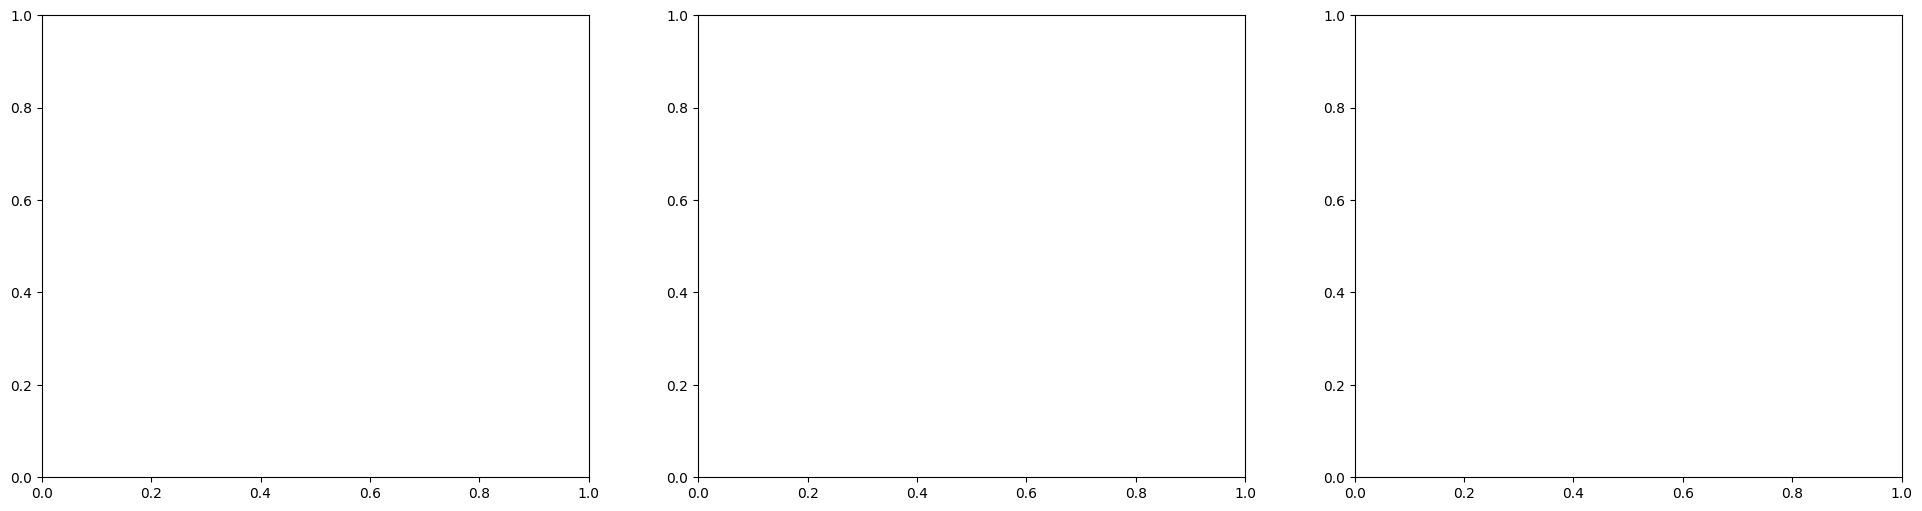

In [16]:
import matplotlib.pyplot as plt

labels = ['BO', 'GD', 'RL-1M', 'RL-2M', 'Max']

# Assuming result_dictionary is already defined with the relevant data
# result_dictionary = {...}

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Font size for the ticks
tick_font_size = 24  # You can change this value as needed

# Plotting Throughput
axes[0].boxplot(result_dictionary['Throughput'], labels=labels)
axes[0].set_title('Throughput',fontsize=24)
axes[0].set_ylabel('Gbps',fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[0].grid(True)  # Adding grid

# Plotting Energy
axes[1].boxplot(result_dictionary['Energy'], labels=labels)
axes[1].set_title('Energy',fontsize=24)
axes[1].set_ylabel('Joules',fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[1].grid(True)  # Adding grid

# Plotting Loss Rate
axes[2].boxplot(result_dictionary['lossRate'], labels=labels)
axes[2].set_title('Loss Rate',fontsize=24)
axes[2].set_ylabel('Percentage',fontsize=24)
axes[2].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[2].grid(True)  # Adding grid

plt.tight_layout()
plt.show()


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

from optimizer_gd import *
# Assuming `transferClass` is defined, and `static` is a function that applies the action
# Assuming `loaded_dfs` and `loaded_initial_dfs` are defined and contain the necessary data

# Initialize the results dictionary
results = {'Throughput': {action: [] for action in range(1, 9)},
           'Energy': {action: [] for action in range(1, 9)},
           'PLR': {action: [] for action in range(1, 9)}}

# Run the experiment
for action in range(1, 9):
    for _ in range(100):
        env = transferClass(loaded_dfs, loaded_initial_dfs, 'random')
        env.reset()
        static(env, action)  # Apply the action using the static function
        accumulator_df = pd.concat(env.obs_df)  # Concatenate observations to a DataFrame
        
        # Record the results
        results['Throughput'][action].append(accumulator_df['Throughput'].mean())
        results['Energy'][action].append(accumulator_df['Energy'].sum())
        results['PLR'][action].append(accumulator_df['sender_lr'].sum())
        
        env.close()



Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action: 1
Static Exits ...
Static Action:

Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits ...
Static Action: 3
Static Exits .

Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 5
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits ...
Static Action: 6
Static Exits .

Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits ...
Static Action: 8
Static Exits .

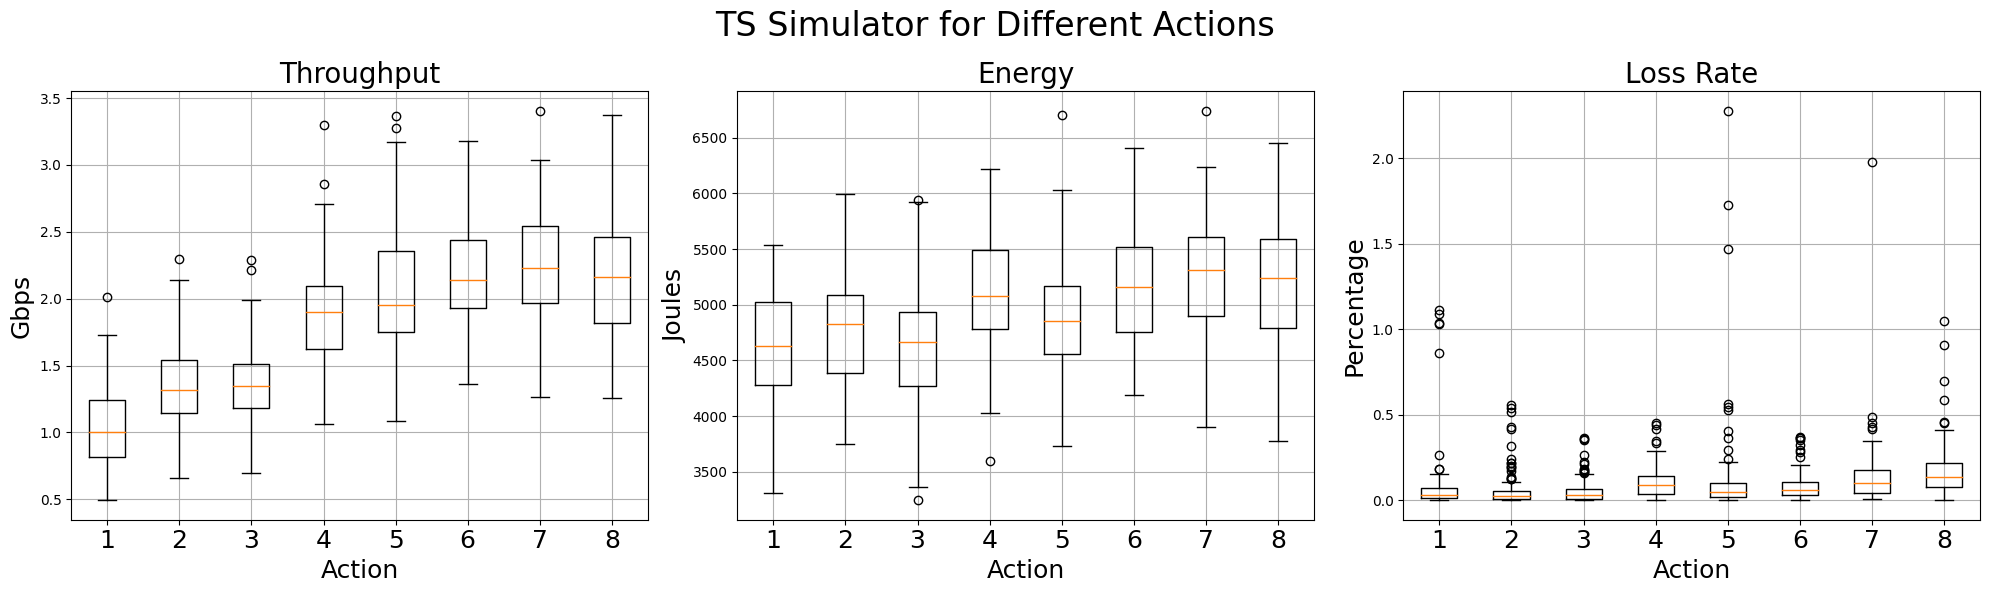

In [18]:
# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Wider figure for three subplots

# Throughput
axes[0].boxplot([results['Throughput'][action] for action in range(1, 9)])
axes[0].set_title('Throughput', fontsize=20)  # Increased title font size
axes[0].set_xticklabels(range(1, 9), fontsize=18)  # Increased x-tick label font size
axes[0].set_xlabel('Action', fontsize=18)  # Increased x-axis label font size
axes[0].set_ylabel('Gbps', fontsize=18)  # Increased y-axis label font size
axes[0].grid(True)  # Enable grid

# Energy
axes[1].boxplot([results['Energy'][action] for action in range(1, 9)])
axes[1].set_title('Energy', fontsize=20)
axes[1].set_xticklabels(range(1, 9), fontsize=18)
axes[1].set_xlabel('Action', fontsize=18)
axes[1].set_ylabel('Joules', fontsize=18)
axes[1].grid(True)

# PLR
axes[2].boxplot([results['PLR'][action] for action in range(1, 9)])
axes[2].set_title('Loss Rate', fontsize=20)
axes[2].set_xticklabels(range(1, 9), fontsize=18)
axes[2].set_xlabel('Action', fontsize=18)
axes[2].set_ylabel('Percentage', fontsize=18)
axes[2].grid(True)
plt.suptitle('TS Simulator for Different Actions',fontsize=tick_font_size)
plt.tight_layout()
plt.show()
